Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "MorningStar"

# Homework 2-1: Predicting Housing Prices (预测房价)

### Collaboration Policy (合作政策)

Data science is a <font color=orange>collaborative activity</font> (合作活动). While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the <font color=orange>assignments</font> (作业) with others please **include their names** at the top of your solution.

## Introduction
In this homework, we will go through the iterative process of 「<font color=red>specifying</font>」, 「<font color=red>fitting</font>」, and 「<font color=red>refining</font>」 a model.  

In the first <font color=orange>portion</font> (部分) of the assignment, we will guide you through some 「**basic EDA**」, laying out the thought process that leads to certain modeling decisions.  We will then 「**specify and fit two linear models**」, providing an example of the type of code we expect from you in the open-response.

The second part of the assignment is purposefully left open-ended.  You will be allowed to <font color=blue>build a linear model of your choice</font>.

After this homework, you should feel comfortable with the following:

1. Working with a 「**messy data set**」 that requires a moderate amount of cleaning and wrangling
1. Using 「**sklearn**」 to build models
1. Using several different 「**transformations**」 on your data
1. Building a data pipeline using 「**pandas**」
1. Using 「**cross-validation**」 for model selection

### You may find some standoffish empty cells with only a comment in them in this assignment.  They are there on purpose; please do not attempt to modify them.


## Short Proofs

We have data $(x_1, y_1) ... (x_n, y_n)$ drawn independently from the same distribution $P(x, y)$.  Our goal is to use a 「**linear model**」 to describe the relationship between $x$ and $y$.

$$ f_\theta(x) = \theta_1 + \theta_2 x $$

We fit $\hat{\theta}_1$ and $\hat{\theta}_2$ by minimizing average $L_2$ loss $$ \hat\theta = \text{argmin}_{\theta_1, \theta_2}\frac{1}{n}\sum_{i=1}^n (y_i - f_\theta(x_i))^2$$.

##### Part a <a name="q1a"></a>
The fitted/predicted y-values are given by:

$$ \hat{y}_i = f_\hat\theta(x_i) = \hat\theta_1 + \hat\theta_2 x_i $$

The **residuals** are defined as:

$$ e_i = \text{observed } y_i - \text{predicted } y_i = y_i - \hat y_i $$

Then the sum of the residuals is equal to 0.  In other words, 

$$\sum_{i=1}^n e_i = 0$$

### 查看 ipynb 所用的虚拟环境

In [2]:
import sys
sys.executable

'/opt/anaconda3/envs/ML_EXP/bin/python'

### 导入必要的包

In [3]:
# ----- 数据处理相关的包 ----- #
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype


# ----- 画图相关的包 ----- #
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ----- 机器学习相关的包 ----- #
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


# ----- 画图参数设置 ----- #
# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12


# ----- 显示中文 ----- #
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False


# ----- 设置输出相关 ----- #
from pprint import pprint

# The Data

The Ames data set consists of 2930 records taken from the Ames Assessor’s Office.  The data set has <font color=red>23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total</font>.  An 「**explanation**」 of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.  **Some noise has been added to the actual sale price, so prices will not match official records.** (<font color=orange>存在一些「噪声」，价格与官方记录未完全一致</font>)

The data are split into 「**training**」 and 「**test**」 sets with 2000 and 930 observations, respectively.  The actual sale price is withheld from you in the test set.  In addition, the test data are further split into 「**public**」 and 「**private**」 test sets.  When you upload a test set prediction onto Kaggle for validation, the score you receive will be calculated using the 「**public test set**」.  The 「**private test set**」 will be used in a final evaluation of this homework assignment.

**public test set**：<font color=orange>需要向 Kaggle 上传文件</font> <br>
**private test set**：<font color=orange>用于本次的作业测试</font>

In [4]:
# ----- 读取数据 ----- #
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the <font color=blue>data shape matches the description</font>.

In [5]:
# ----- 检验数据是否合格 ----- #
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the 「**variables**」 in our data.  

The Ames data set contains 「**information**」 that <font color=blue>typical homebuyers would want to know</font>.  

A <font color=red>more detailed description of each variable</font> is included in `codebook.txt`. 

**You should take some time to familiarize yourself with the codebook before moving forward.**

In [6]:
# ----- 查看所有的变量信息 ----- #
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Guided Modeling

In the first portion of the assignment, we will take you 「**step-by-step**」 through one cycle of the 「**modeling process**」.  Along the way, we will provide <font color=orange>commentary</font> (评论) to <font color=red>give you a sense of the thought process that goes into building a model</font>.

## EDA
Naturally, the 「**first thing**」 we want to do is <font color=blue>get a feel for our data</font>.  

In this section, we will make a series of exploratory visualizations.  The plots we ask you to reproduce here are <font color=orange>far from exhaustive</font> (不够详尽).  

**When you build your own model in the second part of this assignment, you will want to <font color=orange>delve deeper into the data</font>.** (深入研究数据)

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (yet another name for a combination of a KDE, a boxplot, and a boxplot all-in-one) of our target variable `SalePrice`.  

At the same time, we also take a look at some <font color=red>descriptive statistics of this variable</font>.

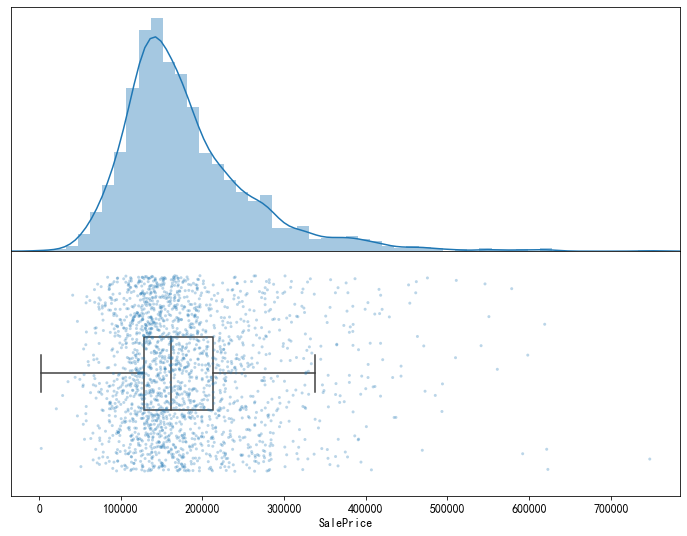

In [7]:
# ----- 绘制图片 ----- #
# 创建两个画布
fig, axs = plt.subplots(nrows=2)

# 绘制「hist」
sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0],
)

# 绘制「散点图」
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)

# 绘制「箱线图」
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# ----- 其他细节处理 ----- #
# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
# 设置 x 轴的范围
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# 让一些轴「不可见」
# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# 把两张图放一起
# Put the two plots together
plt.subplots_adjust(hspace=0)

# 将「箱线图」调成白色
# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [8]:
# 对数据中每一列数进行统计分析；（以“列”为单位进行统计分析）
"""
count：一列的元素个数；
mean：一列数据的平均值；
std：一列数据的均方差；
min：一列数据中的最小值；
max：一列数中的最大值；
25%：一列数据中，前 25% 的数据的平均值；
50%：一列数据中，前 50% 的数据的平均值；
75%：一列数据中，前 75% 的数据的平均值；
"""
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

#### Question 1 <a name="q2"></a>
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is <font color=orange>left-skew</font> (左偏的).
1. The mean of `SalePrice` in the training set is greater than the median.
1. 75% of the houses in the training set sold for less than \$213,125.00.

In [9]:
# ----- 输出「SalePrice」的中位数 ----- #
print(training_data['SalePrice'].median())

162000.0


In [10]:
# These should be True or False
q1statement1 = True
q1statement2 = True
q1statement3 = False

In [11]:
# Two of these statements are True.
assert sum([q1statement1, q1statement2, q1statement3]) == 2

In [12]:
# Yes, this is a cell with just a comment.
"""Question 3：75% 的平均数是 $213,125.00，而不是有 75% 的价格少于 $213,125.00"""

'Question 3：75% 的平均数是 $213,125.00，而不是有 75% 的价格少于 $213,125.00'

### SalePrice vs Gr_Liv_Area

Next, we examine `SalePrice` vs `Gr_Liv_Area`.  

Now it's not entirely obvious what `Gr_Liv_Area` should be, so we'll need to consult `codebook.txt`.  We find:

```
Gr Liv Area (Continuous): Above grade (ground) living area square feet
地上起居面积「平方英尺」
```

Ok, so this variable represents the square footage of the house <font color=orange>excluding anything built underground</font> (不包括地下建造的任何东西).  

Some additional research (into real estate conventions) reveals that this value also <font color=orange>excludes the garage space</font> (不包括「**车库空间**」).

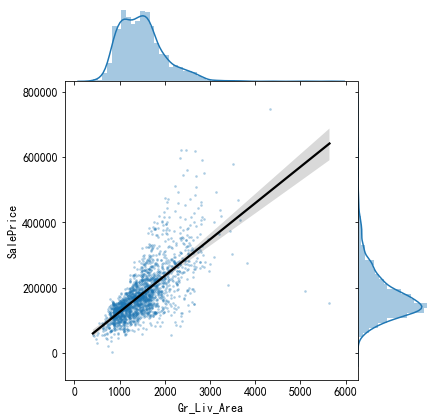

In [13]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)

We notice that there is a 「**plausible linear relationship**」 between 「**house size**」 and 「**sale price**」, but <font color=orange>the spread is wider at 「larger sale prices」 and 「above grade living areas」</font> (在更高的「销售价格」和更高「等级」的生活区中，价差更大).  There seem to be 「**two particularly suspicious houses**」 above 5000 square feet.

#### Question 2 <a name="q3"></a>
What are the 「**Parcel Indentification Numbers**」 for the two houses with `Gr_Liv_Area` greater than 5000 sqft?

In [14]:
# ----- 取出「Gr_Liv_Area」超过 5000 sqft 的编号 ----- #
data_big = training_data[training_data["Gr_Liv_Area"]>5000]
print(data_big["PID"]) 

1014    908154235
1471    908154195
Name: PID, dtype: int64


In [15]:
# Hint: You can answer this question purely through pandas
# q2house1 and q2house2 should be integers
q2house1 = 908154235
q2house2 = 908154195

In [16]:
assert isinstance(q2house1, int)
assert isinstance(q2house2, int)

In [17]:
# Yes, this is a cell with just a comment. Watcha gonna do?
"""发现异常数据，可以剔除它们"""

'发现异常数据，可以剔除它们'

#### Question 3 <a name="q4b"></a>

Write a function `remove_outliers` that 「**removes outliers**」 from a data set based off a threshold value of a variable.  

For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

In [18]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
        
    # ----- 清除异常值 ----- #
    data = data[data[variable] < upper]
    data = data[data[variable] > lower]

    return data

training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [19]:
# ----- 确保仅有「两个值」被「剔除」----- #
# Make sure that two observations were removed
assert training_data.shape[0] == 1998

### Neighborhood vs Sale Price

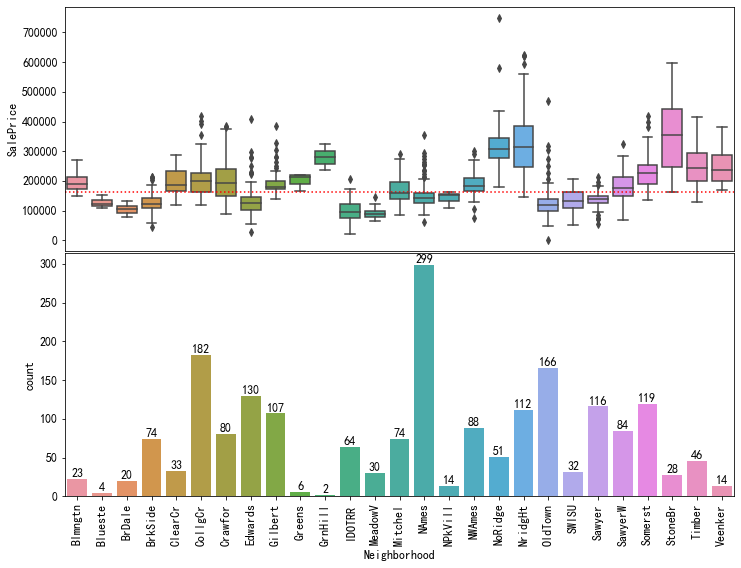

In [20]:
# ----- 绘制图片 ----- #
# 创建两个画布
fig, axs = plt.subplots(nrows=2)


# 箱线图 
sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)


# 计算「Neighborhood」的数量
sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)


# ----- 细节处理 ----- #
# 「红线」标出中位数位置
# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)


# 标出「counts」值
# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    
# 设置 x-axes 的字母
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)


# 缩小「plots」间的距离
# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

In [21]:
# ----- 输出「neighborhoods」的不同值 ----- #
print(training_data['Neighborhood'].unique())

['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'BrkSide'
 'OldTown' 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste'
 'IDOTRR' 'Mitchel' 'Timber' 'MeadowV' 'Veenker' 'GrnHill']


       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       Greens	Greens
       GrnHill	Green Hills
       IDOTRR	Iowa DOT and Rail Road
       Landmrk	Landmark
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

From the plot above, it becomes clear that <font color=orange>there is quite some variation in prices across neighborhoods</font> (不同「**街区**」的价格存在很大差异).  

Moreover, the amount of data available is not <font color=orange>uniformly distributed</font> (均匀分布) among neighborhoods.  「North Ames」, for example, comprises almost 「15% of the training data」 while 「Green Hill」 has a scant（不足的） 「2 observations」 in this data set.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  
Let's <font color=orange>dichotomize</font>（对分） our neighborhoods in a very crude way: we'll take the 「**top 3 neighborhoods**」 measured by median `SalePrice` and identify them as "rich neighborhoods"; 「**the other**」 neighborhoods are not marked.

#### Question 4 <a name="q5"></a>

Write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

In [22]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    # ----- 获取 str ----- #
    neighborhoods = data["Neighborhood"].unique() 
    
    # ----- 保存数据 ----- #
    metric_list = {}
    for i in neighborhoods:
        temp = data[data["Neighborhood"]==i]
        metric_list[i] = metric(temp["SalePrice"])

    metric_list_sorted = sorted(metric_list.items(), key=lambda i:(i[1], i[0]), reverse=True)

#     pprint(metric_list_sorted)
    
    # ----- 获取前 N 个有钱人 ----- #
    rich_list = []
    for i in range(n):
        rich_list.append(metric_list_sorted[i][0])
#         print(metric_list_sorted[i][0])
        
    return rich_list

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [23]:
# ----- 检查是否写的正确 ----- #
# Check to see if the n argument works
assert len(find_rich_neighborhoods(training_data, 5, np.median)) == 5
assert isinstance(rich_neighborhoods, list)
# Check to see if the list contains only strings
assert all([isinstance(neighborhood, str) for neighborhood in rich_neighborhoods])

## Missing Data

#### Question 5 <a name="q6"></a>
Let's see if our data set has any 「**missing values**」.  

Create a Series object <font color=red>containing the counts of missing values</font> in each of the columns of our data set sorted from greatest to least.  

The Series should be indexed by the 「**variable names**」.  

For example, `missing_counts['Fireplace_Qu']` should return 975.

In [24]:
# ----- 缺失值计数 ----- #
# 遍历每个变量，获取缺失值
missing_counts = {}
for temp in training_data:
    temp_miss = training_data[temp].isnull().sum()
    missing_counts[temp] = temp_miss    

# 将「列表」转换为「Series」
missing_counts = pd.Series(missing_counts)

In [25]:
# ----- 检验是否写的有问题 ----- #
# Make sure your answer is a Series
assert isinstance(missing_counts, pd.Series)
# Make sure all columns are represented
assert missing_counts.size == 82
# Make sure your index values match column names
assert set(missing_counts.index.values) == set(training_data.columns.values)

It turns out that if we look at the codebook carefully, some of these "missing values" <font color=red>aren't missing at all!</font> 

The Assessor's Office just used `NA` to <font color=blue>denote a special value</font> or that <font color=blue>the information was truly not applicable</font> for one reason or another.  

One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

#### Question 6 <a name="q7"></a>

An `NA` here actually means that the house had no fireplace to rate.  

Let's 「**fix**」 this in our data set.  

Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  

In addition, it should replace each abbreviated condition with its full word.  

For example, `'TA'` should be changed to `'Average'`.  

Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.


In [26]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    
    # ----- 执行替换 ----- #
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace(np.nan, "No Fireplace")
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace("Ex", "Excellent")
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace("Gd", "Good")
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace("TA", "Average")
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace("Fa", "Fair")
    data["Fireplace_Qu"] = data["Fireplace_Qu"].replace("Po", "Poor")
    
    return data
    
training_data = fix_fireplace_qu(training_data)

In [27]:
# ----- 检验是否写的有问题 ----- #
# Make sure you've replaced all the missing values with 'No Fireplace'
assert sum(training_data['Fireplace_Qu'] == 'No Fireplace') == 975

It turns out that simply fixing these missing values <font color=red>isn't sufficient</font> for using `Fireplace_Qu` in our model.  

Since `Fireplace_Qu` is a categorical/nominal variable, we will have to 「**one-hot-encode**」 the data.  

Notice in the example code below that we have to pre-specify the categories.  

Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  

For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).  

**Note that `get_dummies` removes the original column.** 

In [28]:
# ----- 未看懂??? ----- #
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  
    New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data['Fireplace_Qu'] = data['Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [29]:
# ----- 显示替换后的「前 10 行」 ----- #
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


## Feature Engineering

In this section we will <font color=blue>create a new feature</font> out of existing ones <font color=blue>through a simple data transformation.</font>  

When you move on to create your own model, you may want to try out 「**more complex transformations**」.

### Bathrooms

We will create a groundbreaking new feature.  

Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ TotalBathrooms=(BsmtFullBath + FullBath) + \dfrac{1}{2}(BsmtHalfBath + HalfBath)$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

#### Question 7 <a name="q8"></a>

Write a function `add_total_bathrooms(data)` that returns the input data frame with a new column called `total_bathrooms` as calculated above.  

**Treat missing values as 0s**.  (<font color=red>「缺失值」视为 0</font>)

Remember that you can <font color=blue>make use of vectorized code here.</font>

In [30]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    Output:
      data frame identical to the input with the addition of a total_bathrooms column
    """
    
    # ----- 替换缺失值 ----- #
    data["Bsmt_Full_Bath"] = data["Bsmt_Full_Bath"].replace(np.nan, 0)
    data["Full_Bath"] = data["Full_Bath"].replace(np.nan, 0)
    data["Bsmt_Half_Bath"] = data["Bsmt_Half_Bath"].replace(np.nan, 0)
    data["Half_Bath"] = data["Half_Bath"].replace(np.nan, 0)
    
    
    # ----- 添加新列 ----- # 
    data["total_bathrooms"] = (data["Bsmt_Full_Bath"] + data["Full_Bath"]) + 0.5*(data["Bsmt_Half_Bath"] + data["Half_Bath"])

    
    return data

training_data = add_total_bathrooms(training_data)

In [31]:
# Check that missing values are dealt with
assert ~training_data['total_bathrooms'].isnull().any()
# Check that the values are as expected
assert training_data['total_bathrooms'].sum() == 4421.5

### Rich Neighborhoods

#### Question 8 <a name="q9"></a>
From before, we have a list of neighborhoods we've deemed as richer than others.  

Let's use that information to <font color=red>make a new variable</font> `in_rich_neighborhood`.  

Write a function `add_rich_neighborhood` that adds an indicator variable which <font color=blue>takes on the value 1</font> if the house is part of `rich_neighborhoods` (question 4) and <font color=red>the value 0 otherwise</font>. 

In [32]:
# ----- 判断单个用户是否为富豪 ----- #
def select_rich_neighborhood(x, neighborhoods):
    if x in neighborhoods:
        return 1 
    else:
        return 0 

def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """

    # ----- 添加新行 ----- #
    values = data["Neighborhood"].apply(lambda x:select_rich_neighborhood(x, neighborhoods)) 
    data["in_rich_neighborhood"] = values
    
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [33]:
# Check to see if you have identified the correct number of rich neighborhoods
assert sum(training_data['in_rich_neighborhood']) == 191
# Check to see if you've introduced any missing values
assert sum(training_data['in_rich_neighborhood'].isnull()) == 0

## Modeling

We've finally gotten to a point <font color=red>where we can specify a simple model</font>.  
But first, we need to create perform a 「**test-train split**」 of our data.  

We begin by <font color=blue>loading a fresh copy of the data</font> in at this point just in case our code above produced any undesired side-effects.  

At this point, we will begin to treat `ames_train.csv` as our complete data set.  

We will use `train_test_split` from `sklearn` to split the data into `test` and `train` sets.

Remember: The reason we have to do a train-test split on `ames_train.csv` here is because we want to evaluate how well our model might perform on future data (`ames_test.csv`), but that data set does not have `SalePrice` in it!

In [34]:
# ----- 重新加载数据 ----- #
# Load a fresh copy of the data
full_data = pd.read_csv("ames_train.csv")


# ----- 进行「训练集」&「测试集」划分 ----- #
# This makes the train-test split in this section reproducible across different runs 
# of the notebook.  You do not need this line to run train_test_split in general
np.random.seed(1337) 

# Split the data 
train, test = train_test_split(full_data, test_size=0.2)

In [35]:
# ----- 检验划分的数据是否正确 ----- #
# Something has gone awry in the cell above if these do not pass
assert test.shape == (400, 82)
assert train.shape == (1600, 82)
assert train.loc[887, 'PID'] == 902402260

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  

From a **software engineering perspective**, this should be sufficient motivation to <font color=red>abstract parts of our code into reusable functions/methods</font>.  

We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [36]:
# ----- 选择「data」的某几列 ----- #
def select_columns(data, *columns):
    return data.loc[:, columns]

def process_data_gm1(data):
    # ----- 清洗数据 ----- #
    # Clean Data
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    data = fix_fireplace_qu(data)
    
    
    # ----- 转换数据 ----- #
    # Transform Data
    data = add_total_bathrooms(data)
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'total_bathrooms',
                          'Fireplace_Qu',
                          'in_rich_neighborhood'
                         )
    data = ohe_fireplace_qu(data)
    
    # ----- 设置「x」和「y」 ----- #
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

An alternative way of writing the same code above explicitly allows us to think about our data flowing through a [pipeline](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) where the output of one function is the input of the next.  Carefully thought out function names make the code self-documenting: you can just read off the intended high-level processing steps from top to bottom.

You are <font color=red>not required to</font> use this style of coding.  

We just wanted to point out that it exists.

In [37]:
def process_data_gm1(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

### Fitting our first model

We are finally <font color=blue>going to fit a model</font>!  

This part is slightly unceremonious since we did much of the heavy lifting in the previous sections.  

The model we will fit can be written as follows (with the caveat that one of the fireplace qualities is actually removed to avoid collinearity):

$$\begin{align} SalePrice = &\theta_0 + \theta_1 \times GrLivArea + \theta_2 \times TotalBathrooms \\
&+ \theta_3 \times InRichNeighborhood + \sum_{quality \in FireplaceQuality} \theta_{quality} \times Quality
\end{align}$$

#### Question 9a <a name="q10a"></a>
Remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

In [38]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm1(train)
X_test, y_test = process_data_gm1(test)
guidedmodel1 = lm.LinearRegression(fit_intercept=True)

# Fill in the ... below with X_train, y_train, X_train, or X_test.
guidedmodel1.fit(X_train, y_train)
y_fitted = guidedmodel1.predict(X_train)
y_predicted = guidedmodel1.predict(X_test)

print("y_fitted: ", y_fitted.mean())
print("y_predicted: ", y_predicted.mean())

y_fitted:  181363.48155096936
y_predicted:  177777.80466801944


In [39]:
assert 181100 <= y_fitted.mean() <= 181400
assert 177700 <= y_predicted.mean() <= 177800

In this assignment, we will use Root-Mean-Square Error (RMSE) to measure the quality of our models.  As a reminder, this quantity is defined as:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in test set}}}$$

#### Question 9b <a name="q10b"></a>

Write a function `rmse` that calculates the RMSE of a model.  

Again, make sure you are taking advantage of vectorized code.  This can be solved without any iteration.

In [40]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    
    
    # ----- 向量计算形式 ----- #
    return np.sqrt(((predicted - actual) ** 2).mean())

In [41]:
assert 43000 <= rmse(y_test, y_predicted) <= 44000

### Residual Plots

One way of diagnosing a model is through a 「**residual plot**」(残差图).  

Here we plot the actual sale prices against the residuals of the model.  Ideally, we would see a horizontal line of points at 0 (perfect prediction!).  The next best thing would be a homogenous set of points centered at 0.  But alas, our simple model is probably too simple.  We notice that we are really underfitting the more expensive homes in the test set.  In fact, it looks like our model tends to underprice the more expensive homes!  You will probably want to address this in your own work.

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

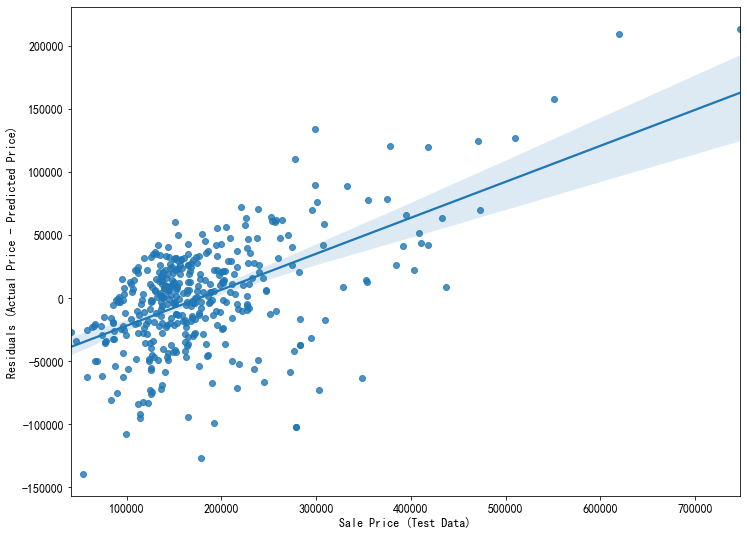

In [42]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

### Regularizing our model

Ok, so let's make our modeling a little <font color=red>more fancy</font> by 「**regularizing the coefficients**」. 

This second model will use the 「**Lasso**」, but you are <font color=blue>free to use 「Ridge」 or 「ElasticNet」</font> in your work.  

First, we need to add a step to our 「**pre-processing**」.  

In order for regularization to be fair to all the variables in our model, we need to <font color=red>standardize our predictor columns</font> (otherwise it would unfairly penalize variables with inherently small values).

#### Question 10 <a name="q11"></a>

Write a function that standardizes the columns of a data frame containing only numeric columns.  Be sure to make use of vectorization.

In [43]:
def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    
    # ----- 标准化 ----- #
    standardized_data = (data-np.mean(data))/np.std(data)
    
    return standardized_data

In [44]:
test_standardize_df = standardize_columns(training_data[['SalePrice', 'Gr_Liv_Area']])
# Make sure the mean is correct
assert -0.001 < test_standardize_df.mean().sum() < 0.001
# Make sure the standard deviation is correct
assert 1.9 < test_standardize_df.std().sum() < 2.1

We'll now use this function to describe our new processing for the regularized model.

In [45]:
def process_data_gm2(data):

    data = (
        data
        # Clean Data
        .pipe(remove_outliers, 'Gr_Liv_Area', upper=5000)
        .pipe(fix_fireplace_qu)
        
        # Transform data
        .pipe(add_total_bathrooms)
        .pipe(add_in_rich_neighborhood, rich_neighborhoods)
        .pipe(select_columns, 
              'SalePrice',           
              'Gr_Liv_Area',            
              'total_bathrooms',             
              'Fireplace_Qu',            
              'in_rich_neighborhood'
             )
        .pipe(ohe_fireplace_qu)
    ) 
    
    # Return predictor and response variables separately
    X = standardize_columns(data).drop(['SalePrice'], axis = 1)
    y = data['SalePrice']
    
    return X, y

It may be instructive to see the 「**cross-validation**」(交叉验证) procedure explicitly once.  

You should be able to <font color=red>understand what each part of the code is doing below</font>, but we do 「**not expect**」 you to use this code for your own model (use [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instead).

In [46]:
# ----- 处理数据 ----- #
# Process our data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# ----- 建立模型 ----- #
# Specify our model
guidedmodel2 = lm.Lasso(copy_X=True)


# Specify CV method and alpha grid
five_fold_cv = KFold(n_splits = 5)
alphas = np.arange(0.1, 200.1, .1)
rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0
    
    # Fit each fold using the other four as training data
    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]
        
        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)
        model_rmse += rmse(y_fold_test, y_fold_predicted)
    
    # Average RMSE over the five folds for alpha_i
    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)]
guidedmodel2.set_params(alpha=optimal_alpha)
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={float(optimal_alpha)} is {rmse(y_test, y_predicted)}.')

The validation RMSE for this model with alpha=56.2 is 43511.83166496811.


### Lasso Path

Let's take a look at how RMSE varied across different choices of the regularization hyperparameter ($\lambda$ in lecture, `alpha` in `sklearn`).  

This is often called the Lasso or Regularization Path.  

The 「**dashed red line**」 marks the alpha that minimizes RMSE.

Text(0, 0.5, 'RMSE')

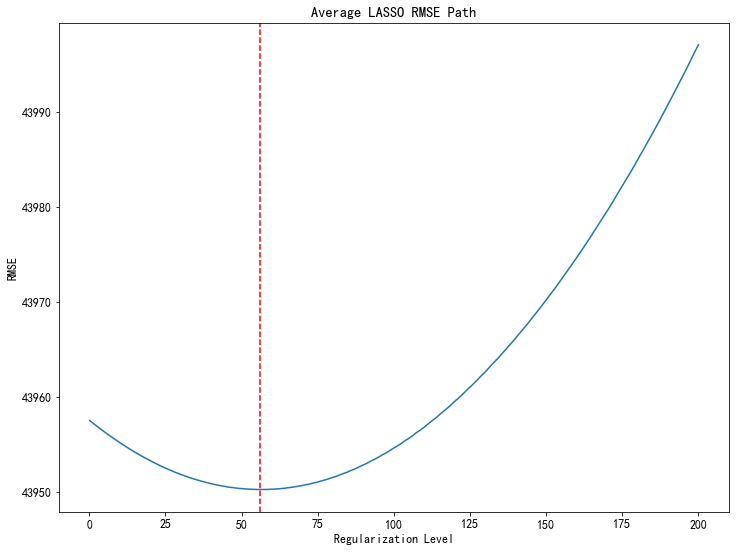

In [47]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('Regularization Level')
ax.set_ylabel('RMSE') 

### A simplified approach to Lasso and CV

Here we perform another L1-regularized regression but using `LassoCV`.  This is more in line with what we expect from you code-wise.  That being said, you should still understand the concepts from the previous section.

In [48]:
# Process the data
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
guidedmodel2 = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
guidedmodel2.fit(X_train, y_train)
y_predicted = guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=55.8 is 43511.9.


Again, we can map out the path that the Lasso algorithm took.

Text(0, 0.5, 'RMSE')

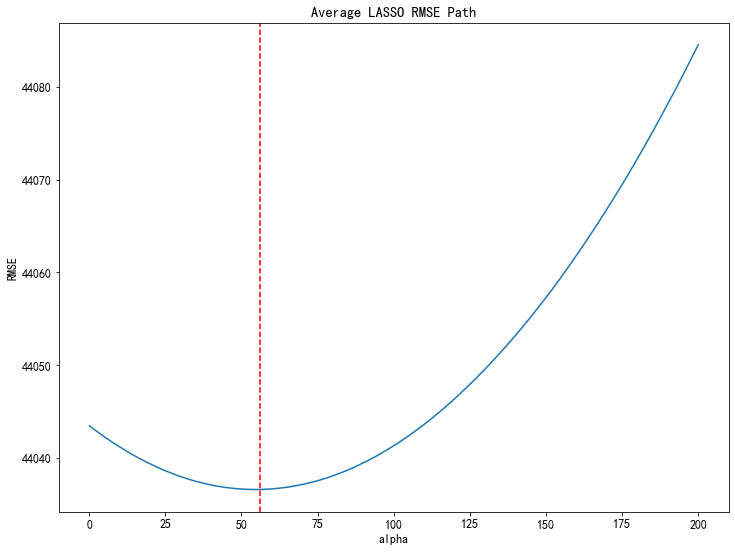

In [49]:
plt.plot(guidedmodel2.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
plt.axvline(x=optimal_alpha, color='red', linestyle='dashed')
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path') 
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

### Lasso Residual Plot

Looking at the residual plot for our L1 regularized linear model, it's clear the regularization did not solve the problems we saw in the simple model.  It seems you have your work cut out for you!

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

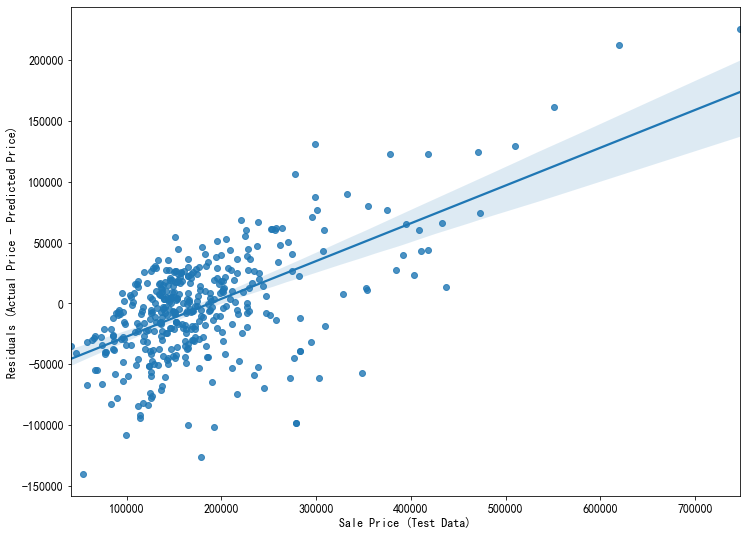

In [50]:
gm2_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm2_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')